In [2]:
import numpy as np
import tensorflow as tf
import os

from triplet_dataset_loader import *
from TL_class import SiameseTripletModel
from TL_siamese_network import generate_siamese_triplet_network
from top_accuracy_functions import *

In [3]:
database_path = "../databases/my-fruit-recognition"
split_ratio = (0.8, 0.2, 0)
image_size = (100,100)
batch_size = 32

auto = tf.data.AUTOTUNE

learning_rate = 0.0001
steps_per_epoch = 50
validation_steps = 10
epochs = 5

# Model Creation & Training

In [4]:
train_dataset, val_dataset, test_dataset = create_dataset(database_path, split_ratio, image_size, batch_size)
triplet_siamese_network = generate_siamese_triplet_network(image_size)
triplet_siamese_model = SiameseTripletModel(triplet_siamese_network)
triplet_siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
triplet_siamese_model.summary()

Model: "siamese_triplet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ ?                      │    40,565,632 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,565,632 (154.75 MB)

 Trainable params: 25,907,712 (98.83 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [4]:
history = triplet_siamese_model.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs
)

Epoch 1/5
14/50 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4537 - loss: 0.4815

KeyboardInterrupt: 

# Extracting embedding layers

In [5]:
embedding_model = triplet_siamese_network.get_layer("Embedding")

## Getting reference images and their embeddings

In [16]:
base_test_folder = "../databases/my-fruit-recognition"
first_image_paths = []

for root, dirs, files in os.walk(base_test_folder):
    files = [f for f in files if f != ".DS_Store"]
    if files:
        files_sorted = sorted(files)
        first_image_path = os.path.join(root, files_sorted[0])
        first_image_paths.append(first_image_path)

# Wyświetlenie listy ścieżek
# for path in first_image_paths:
#     print(path)

In [7]:
mapF = MapFunction(image_size)
first_images = [mapF.decode_and_resize(image_path) for image_path in first_image_paths]
first_images = tf.convert_to_tensor(first_images)
first_embeddings = embedding_model.predict(first_images)
# print(first_embeddings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


## Get query images and predict their embeddings

In [17]:
query_image_path = "../databases/my-fruit-recognition/Banana/Banana01.png"
query_image = mapF.decode_and_resize(query_image_path)

query_image = tf.expand_dims(query_image, axis=0)  # Add batch dimension
query_embedding = embedding_model.predict(query_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


## Top 1 accuracy

In [18]:
closest_vector = top1_accuracy(query_embedding, first_embeddings)
closest_image_index = np.argmin([euclidean_distance(closest_vector, vec) for vec in first_embeddings])

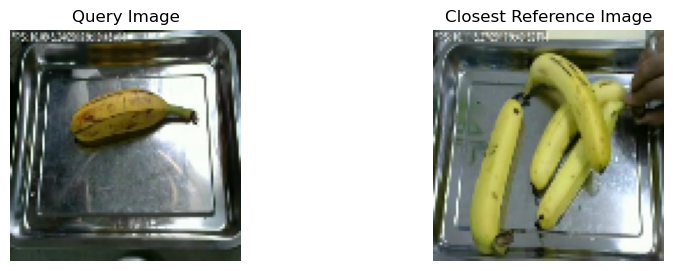

In [19]:
show_top1_accuracy(first_image_paths, closest_image_index, query_image_path, mapF)

## Top 3 accuracy

In [20]:
closest_3_vectors = top3_accuracy(query_embedding, first_embeddings)

closest_3_indices = [np.argmin([euclidean_distance(vec, ref_vec) for ref_vec in first_embeddings]) for vec in closest_3_vectors]

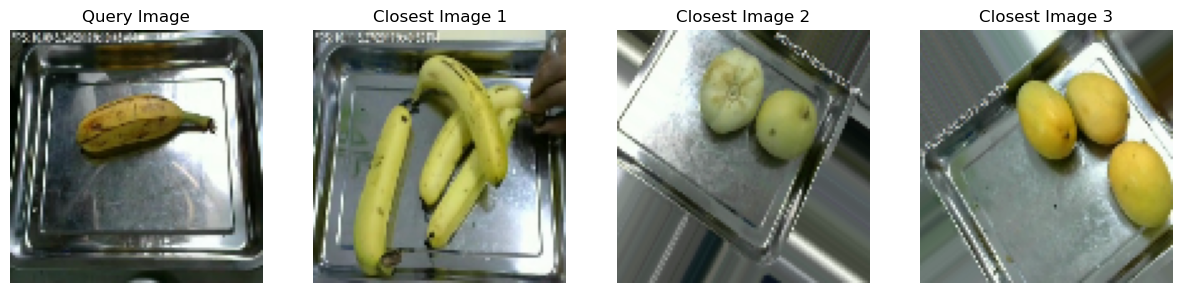

In [21]:
show_top3_accuracy(first_image_paths, closest_3_indices, query_image_path, mapF)